In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


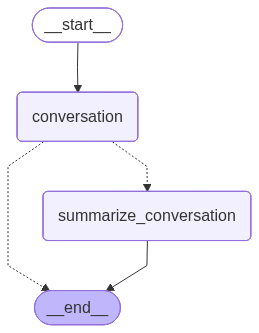

In [2]:
from IPython.display import Image, display
from typing import Literal

from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatGroq(model="openai/gpt-oss-20b")

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State)-> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Rao")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello Rao! How can I help you today?', additional_kwargs={'reasoning_content': 'User says hi. Just greet.'}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 75, 'total_tokens': 102, 'completion_time': 0.026571343, 'prompt_time': 0.003541791, 'queue_time': 0.049465268, 'total_time': 0.030113134}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_77f8660d1d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--197db079-a036-429e-a097-d532f73c8bae-0', usage_metadata={'input_tokens': 75, 'output_tokens': 27, 'total_tokens': 102})}}


In [4]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Rao")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hello Rao! 👋 How can I help you today?


In [5]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Rao")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Rao
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Rao
================================== Ai Message ==================================

Hello Rao! 👋 How can I help you today?
---------------------------------------------------------------------------


In [6]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the Real Madrid football team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conver

In [7]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the Real Madrid football team in a concise manner.")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'groq'}, id='lc_run--16c00146-7954-4aa2-82e8-0a32f9252109')}
{'chunk': AIMessageChunk(content='', additional_kwargs={'reasoning_content': 'We'}, response_metadata={'model_provider': 'groq'}, id='lc_run--16c00146-7954-4aa2-82e8-0a32f9252109')}
{'chunk': AIMessageChunk(content='', additional_kwargs={'reasoning_content': ' need'}, response_metadata={'model_provider': 'groq'}, id='lc_run--16c00146-7954-4aa2-82e8-0a32f9252109')}
{'chunk': AIMessageChunk(content='', additional_kwargs={'reasoning_content': ' to'}, response_metadata={'model_provider': 'groq'}, id='lc_run--16c00146-7954-4aa2-82e8-0a32f9252109')}
{'chunk': AIMessageChunk(content='', additional_kwargs={'reasoning_content': ' give'}, response_metadata={'model_provider': 'groq'}, id='lc_run--16c00146-7954-4aa2-82e8-0a32f9252109')}
{'chunk': AIMessageChunk(content='', additional_kwargs={'reasoning_content': ' concise'}, response_metadata=

In [8]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the Real Madrid football team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||**|Real| |Madrid| Club| de| F|útbol| –| Quick| Reference|**

||| Item| || Details| |
|||------|||---------||
||| **|Founded|**| || |6| March| |190|2| (|original|ly| as| *|Madrid| Football| Club|*|).| |
||| **|Location|**| || Madrid|,| Spain|.| |
||| **|St|adium|**| || **|S|antiago| Bern|ab|é|u| Stadium|**| –| |81|,|044| seats| (|ren|ov|ated| |201|9|‑|202|1|).| |
||| **|League|**| || La| |Liga| (|Spanish| Primera| División|).| |
||| **|Colors|**| || White| home| kit|,| blue| away|/|third| kits|.| |
||| **|Nickname|**| || *|Los| Blanc|os|*| (|The| Whites|),| *|Los| Mer|eng|ues|*| (|The| M|ering|ues|).| |
||| **|Official| Website|**| || [|realm|adrid|.com|](|https|://|www|.realm|adrid|.com|)| |

|---

|##| |1|.| Historical| Highlights|

||| Era| || Key| Events| |
|||-----|||------------||
||| **|Early| Years| (|190|2|‑|193|0|s|)**| || First| Spanish| league| title| in| |193|2|‑|33|;| early| rivalry| with| Atlético|